In [1]:
!pip install torchvision

In [1]:
import os
import json

from PIL import Image
from tqdm.notebook import tqdm
import gc
import numpy as np
import pandas as pd
import time
import copy
from collections import Counter

# from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
import torch.nn.init as init

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from timm.scheduler.scheduler import Scheduler
from timm.loss import LabelSmoothingCrossEntropy
import timm

from torchvision import transforms as T
import torchvision
# from transformers import AutoImageProcessor, ResNetModel
from transformers import ViTFeatureExtractor, ViTForImageClassification
# from transformers.image_processing_base import BatchFeature

2024-08-21 05:45:28.125189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 05:45:28.125403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 05:45:28.342051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Preparation

In [2]:
def data_builder(label_path, train = True):
    # read annotations
    df = pd.read_csv(label_path, names = ['image', 'val', 'arousal', 'expr', 'au1', 'au2', 'au3', 'au4', 'au5', 'au6', 'au7', 'au8', 'au9', 'au10', 'au11', 'au12'] )
    # Remove the first row
    df = df.drop(index=0)

    # reset index
    df = df.reset_index(drop=True)

    df[['folder', 'image']] = df['image'].str.split('/', expand=True)

    grouped = df.groupby(['folder'], as_index= False).apply(lambda x: x.sort_values('image'))
    grouped['expr'] = grouped['expr'].astype(int)
    grouped = grouped.reset_index(drop=True)

    # generating data dictionary
    data_dict = {}
    emo = ['Neutral', 'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness','Surprise', 'Other']
    seq = 0
    current = -1
    for index, row in grouped.iterrows():
        if row['expr'] != current:
            current = row['expr']
            if train:
                seq += 1

        if row['expr'] == -1:
            continue

        if row['folder'] in data_dict:
            if f"{emo[row['expr']]}{seq}" in data_dict[row['folder']]:
                data_dict[row['folder']][f"{emo[row['expr']]}{seq}"].append(
                    (os.path.join(row['folder'], row['image']), row['expr'])
                )
            else:
                data_dict[row['folder']][f"{emo[row['expr']]}{seq}"] = [(os.path.join(row['folder'], row['image']), row['expr']), ]
        else:
            data_dict[row['folder']] = {
                f"{emo[row['expr']]}{seq}" : [(os.path.join(row['folder'], row['image']), row['expr']), ],
            }
            
    return data_dict

def most_common_element(lst):
    if not lst:
        return None  # Return None if the list is empty
    counter = Counter(lst)
    most_common = counter.most_common(1)[0]  # Get the most common element
    return most_common[0]

def sequence_extractor(data_dict, data_path, min_stride = 5, sequence_length = 5, train = True):
    train_seqs = []
    train_labels = []
    for folder in data_dict.keys():
        for seq in data_dict[folder].keys():
            s_len = len(data_dict[folder][seq])
            gap = min((s_len - 1) // 4, min_stride)
#             if train:
#                 if s_len > 50:
#                     num_sequences = (s_len - 50) // 50
#                     for i in range(num_sequences):
#                         start_index = i * 50
#                         sequence = [os.path.join(data_path, data_dict[folder][seq][start_index + j * gap][0]) for j in range(sequence_length)]
#                         train_seqs.append(sequence)
#                         train_labels.append(data_dict[folder][seq][0][1])

#                 if s_len >= sequence_length:
#                     middle_index = (s_len - 1) // 2
#                     start_index = middle_index - 2 * gap
#                     selected_elements = [os.path.join(data_path, data_dict[folder][seq][start_index + i * gap][0]) for i in range(sequence_length)]

#                     train_seqs.append(selected_elements)
#                     train_labels.append(data_dict[folder][seq][0][1])
#             else:
            max_start_index = s_len - (5 - 1) * min_stride
            for i in range(0, max_start_index, 5 * min_stride):
                sublist = [os.path.join(data_path, data_dict[folder][seq][i + j * min_stride][0]) for j in range(5)]
                train_seqs.append(sublist)
                t_lab = [data_dict[folder][seq][i + j * min_stride][1] for j in range(5)]

                train_labels.append(most_common_element(t_lab))
    return train_seqs, train_labels


In [24]:
# len(data_dict['107']['Other0'])
val_seq = []
val_labels = []
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'


def most_common_element(lst):
    if not lst:
        return None  # Return None if the list is empty
    counter = Counter(lst)
    most_common = counter.most_common(1)[0]  # Get the most common element
    return most_common[0]

stride = 4
for key in data_dict.keys():
    for exp in data_dict[key].keys():
        n = len(data_dict[key][exp])
        # Calculate the maximum starting index that allows creating a sublist of length 5
        max_start_index = n - (5 - 1) * stride
        for i in range(0, max_start_index, 5 * stride):
            sublist = [os.path.join(data_path, data_dict[key][exp][i + j * stride][0]) for j in range(5)]
            val_seq.append(sublist)
            t_lab = [data_dict[key][exp][i + j * stride][1] for j in range(5)]
            
            val_labels.append(most_common_element(t_lab))


len(val_seq)
# data_dict['107']['Other0'][0]

728

In [3]:
class ABAWFeatureDataset(Dataset):
    def __init__(self, features, labels, transform = None):
        self.features = features
        self.labels = labels
        self.length = len(labels)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        frames = [Image.open(i).convert('RGB') for i in self.features[idx]]
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        frames = torch.stack(frames)
        frames = frames.permute(1, 0, 2, 3)
        label = self.labels[idx]
        return frames, label

In [4]:
train_label_path = '/kaggle/input/abaw-7-dataset/training_set_annotations.txt'
val_label_path = '/kaggle/input/abaw-7-dataset/validation_set_annotations.txt'
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'

batch_size = 16

train_seqs, train_labels = sequence_extractor(
    data_dict = data_builder(train_label_path),
    data_path = data_path,
    min_stride = 5,
    sequence_length = 5
)

val_seqs, val_labels = sequence_extractor(
    data_dict = data_builder(val_label_path, train = False),
    data_path = data_path,
    min_stride = 5,
    sequence_length = 5,
    train = False
)

train_dataset = ABAWFeatureDataset(train_seqs, train_labels, transform = T.Compose([
        T.RandomHorizontalFlip(p=0.5),  # Flip the frame with a probability of 0.5
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),  # Converts the image to a tensor and normalizes to [0, 1]
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),  # Normalization using ImageNet mean and std
    ])
)
val_dataset = ABAWFeatureDataset(val_seqs, val_labels, transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
    ])
)

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)

dataloaders = {
    "train": data_loader_train,
    "val": data_loader_val
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset)
}

/tmp/ipykernel_33/2798846880.py:3: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(label_path, names = ['image', 'val', 'arousal', 'expr', 'au1', 'au2', 'au3', 'au4', 'au5', 'au6', 'au7', 'au8', 'au9', 'au10', 'au11', 'au12'] )
/tmp/ipykernel_33/2798846880.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['folder'], as_index= False).apply(lambda x: x.sort_values('image'))
/tmp/ipykernel_33/2798846880.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the opera

In [6]:
model = torchvision.models.video.swin3d_b(weights="KINETICS400_IMAGENET22K_V1")

# model = torchvision.models.video.swin3d_b(weights=None)

# state_dict = torch.load('/kaggle/working/trained_model/freezing_epoch_10.pth', map_location=torch.device('cpu'))

# Step 3: Apply the loaded weights to the model
# model.load_state_dict(state_dict)
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
for name, param in model.named_parameters():
    if any(layer_name in name for layer_name in ["features.6", "norm", "avgpool", "head"]):
        param.requires_grad = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = LabelSmoothingCrossEntropy()
#criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)
writer = SummaryWriter('run6')

Downloading: "https://download.pytorch.org/models/swin3d_b_22k-7c6ae6fa.pth" to /root/.cache/torch/hub/checkpoints/swin3d_b_22k-7c6ae6fa.pth
100%|██████████| 364M/364M [00:03<00:00, 108MB/s]  


In [7]:
for name, param in model.named_parameters():
    print(name)

patch_embed.proj.weight
patch_embed.proj.bias
patch_embed.norm.weight
patch_embed.norm.bias
features.0.0.norm1.weight
features.0.0.norm1.bias
features.0.0.attn.relative_position_bias_table
features.0.0.attn.qkv.weight
features.0.0.attn.qkv.bias
features.0.0.attn.proj.weight
features.0.0.attn.proj.bias
features.0.0.norm2.weight
features.0.0.norm2.bias
features.0.0.mlp.0.weight
features.0.0.mlp.0.bias
features.0.0.mlp.3.weight
features.0.0.mlp.3.bias
features.0.1.norm1.weight
features.0.1.norm1.bias
features.0.1.attn.relative_position_bias_table
features.0.1.attn.qkv.weight
features.0.1.attn.qkv.bias
features.0.1.attn.proj.weight
features.0.1.attn.proj.bias
features.0.1.norm2.weight
features.0.1.norm2.bias
features.0.1.mlp.0.weight
features.0.1.mlp.0.bias
features.0.1.mlp.3.weight
features.0.1.mlp.3.bias
features.1.reduction.weight
features.1.norm.weight
features.1.norm.bias
features.2.0.norm1.weight
features.2.0.norm1.bias
features.2.0.attn.relative_position_bias_table
features.2.0.attn

In [7]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, writer, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            if phase == 'train' and (epoch+1) % 5 == 0:
                scheduler.step()
                torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase6_freezing_epoch_{epoch}.pth')
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Calculate F1 score, precision, and recall
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}")
            
            # Log the metrics
            writer.add_scalar(f'{phase}6/Loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}6/Accuracy', epoch_acc, epoch)
            writer.add_scalar(f'{phase}6/F1', epoch_f1, epoch)
            writer.add_scalar(f'{phase}6/Precision', epoch_precision, epoch)
            writer.add_scalar(f'{phase}6/Recall', epoch_recall, epoch)
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    torch.save(model.state_dict(), f'/kaggle/working/trained_model/phase6_freezing_final_epoch_{num_epochs}.pth')  # Save the model
    best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return model


In [8]:
# Increase the message rate limit for printing training progress
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {
    "NotebookApp": {
        "iopub_msg_rate_limit": 10000,  # Increase to 10000 messages/sec
        "rate_limit_window": 10.0,      # Increase the rate limit window to 10 seconds
    }
})

In [9]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, device, writer = writer, num_epochs=20)

Epoch 0/19
----------


  0%|          | 0/156 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Independent Validation

In [20]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [9]:
val_seqs, val_labels = sequence_extractor(
    data_dict = data_builder(val_label_path, train = False),
    data_path = data_path,
    min_stride = 1,
    sequence_length = 5,
    train = False
)

val_dataset = ABAWFeatureDataset(val_seqs, val_labels, transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
    ])
)

data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)


/tmp/ipykernel_34/279247727.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['folder'], as_index= False).apply(lambda x: x.sort_values('image'))


In [10]:
running_loss = 0.0
running_corrects = 0.0
all_preds = []
all_labels = []
            
    
for inputs, labels in tqdm(data_loader_val):
    inputs = inputs.to(device)
    labels = labels.to(device)

#     optimizer.zero_grad()

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects.double() / dataset_sizes['val']

# Calculate F1 score, precision, and recall
epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"{'val'} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f}")
            

  0%|          | 0/191 [00:00<?, ?it/s]

val Loss: 15.9058 Acc: 1.8957 F1: 0.3343 Precision: 0.3455 Recall: 0.3583


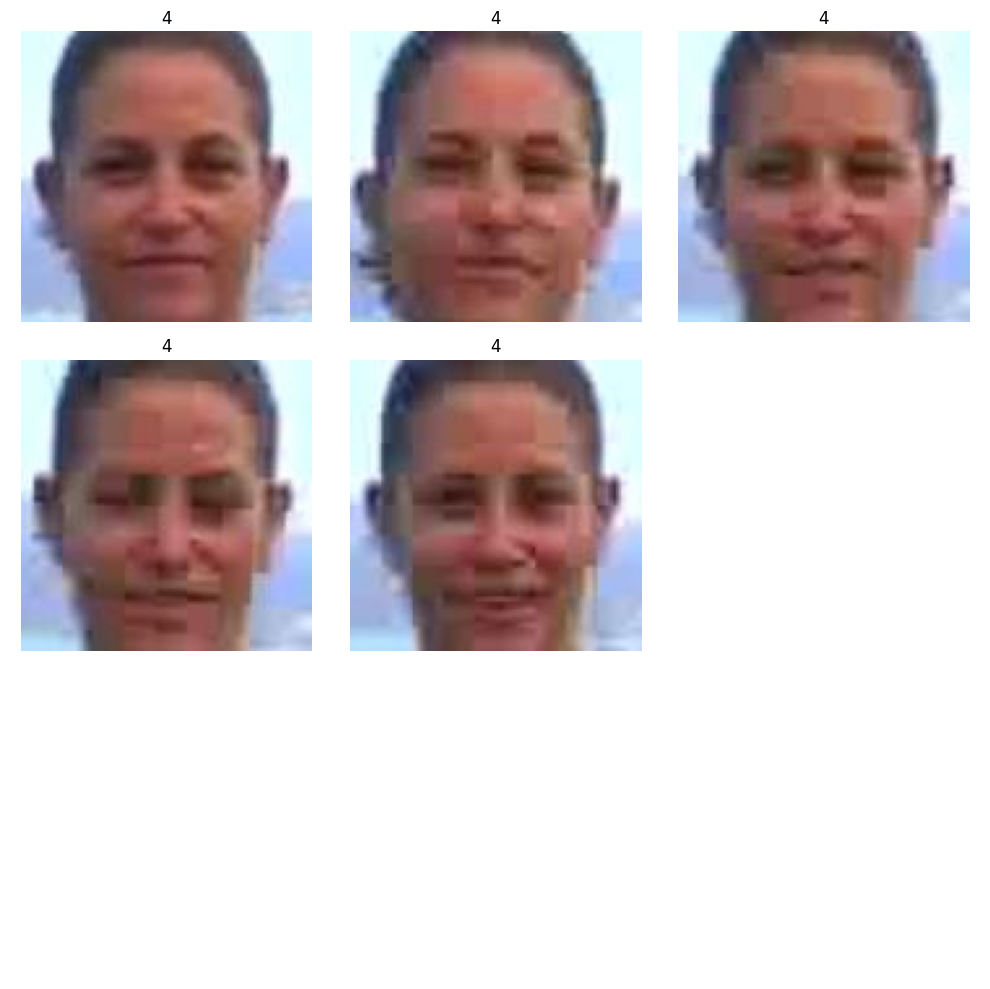

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Example list of image paths
data_path = '/kaggle/input/abaw-7-dataset/cropped_aligned'
image_paths = [os.path.join(data_path, x) for x in train_seqs[0]]
labels = [train_labels[0] for x in train_seqs[0]]
# Number of images
n_images = len(image_paths)

# Calculate grid size (assuming a square grid)
grid_size = int(n_images**0.5) + (n_images**0.5 != int(n_images**0.5))

# Create a figure with a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over images and plot them with labels
for i, (image_path, label) in enumerate(zip(image_paths, labels)):
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(label, fontsize=12)  # Add label

# Hide any remaining empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

[('1-30-1280x720/00001.jpg', 4),
 ('1-30-1280x720/00028.jpg', 4),
 ('1-30-1280x720/00085.jpg', 4),
 ('1-30-1280x720/00116.jpg', 4),
 ('1-30-1280x720/00167.jpg', 4)]

Build a dynamic FER model which takes video 